In [1]:
import time

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline
np.random.seed(3141592)

# Component Wear Analysis

### Contents
* [1. Introduction](#Introduction)
* [2. Data Exploration](#DataExploration)
* [3. Model Definition and Training](#ModelDefinition)
* [4. System Health Estimation](#SystemHealth)
* [5. Anomaly Localization](#AnomalyLocalization)

### 1. Introduction
Many Cyber-Physical Production System (CPPS) contain vital components that are subject to wear or deterioration. Usually, such parts come with an estimated life-time before they should be replaced, however, because of variable product complexity, different materials and workloads or different environmental conditions they can be quite inaccurate. Failure to replace a component in time either results in good parts being scrapped and unnecessary downtime due to repairs, or worse, breakdown of the production/machine because the part was replaced too late.

This is why it is useful to monitor the condition of such components with the help of sensory information. In a complex system, especially when the machine itself is changed irregularly or utilizing changeable parts with slightly different specifications, the manual modelling of the weariness of some subsystem can be quite tedious (albeit very accurate and transparent if done correctly). In contrast, machine learning techniques offer a path to automatic model creation which can be relearned quickly if a system change necessitates it.

In this notebook we will follow the idea of [1] and learn the machine data of the new and functioning CPPS. Instead of a Self-organizing Map, the model that is used is a simple autoencoder that can be considered to be a powerful non-linear generalization of the classical PCA dimensionality reduction procedure.

The *new* data is going to be used for training and validation, while the model will be tested also on the worn component. The autoencoder reconstruction loss will be used as score function indicating the weariness of the component:

$$L_n=\left\Vert x_n-f_\theta\circ g_\theta (x_n)\right\Vert^2$$

where $f_\theta$ is the decoder, $g_\theta$ is the encoder function and $\theta$ are the model parameter that need to be optimized. $x_n$ is the $n^{th}$ datapoint which is a 7-dimensional vector and $\Vert\cdot\Vert$ is the vector norm.

We will work within the tensorflow framework to define the autoencoder model as outlined below and start with a helper function to build the network and define the loss function.

In [2]:
def build_autoencoder(nDim_x, nDim_z, layers_encoder=None, layers_decoder=None, activations=tf.nn.tanh):
    """
    Builds an autoencoder
    :param nDim_x: data input dimension
    :param nDim_z: latent space dimension
    :param layers_encoder: list of intermediary representations, can be empty
    :param layers_decoder: list of intermediary representations, can be empty
    :param activations: tf pointwise activation function
    :return: tuple with tensor elements (input, latent, output, loss_per_datum_and_feature, loss)
    """
    
    layers_encoder = [] if layers_encoder is None else layers_encoder
    layers_decoder = [] if layers_decoder is None else layers_decoder
    
    # input node
    x = tf.placeholder(tf.float32, shape=[None, nDim_x], name="x")
    # encoder neural net
    x_ = x
    for layerSize in layers_encoder:
        x_ = tf.contrib.layers.fully_connected(x_, layerSize, activations)
    
    # latent representation
    z = tf.contrib.layers.fully_connected(x_, nDim_z, None)
    
    # decoder neural net
    x_ = z
    for layerSize in layers_decoder:
        x_ = tf.contrib.layers.fully_connected(x_, layerSize, activations)
    
    # output representation
    y = tf.contrib.layers.fully_connected(x_, nDim_x, None)
    
    distance = tf.square(x - y, name="distance")
    # reconstruction error
    loss = tf.reduce_mean(distance, name="loss")
    
    print("Autoencoder network layers (inclusive in- and output neurons):  {0}".format([nDim_x] + layers_encoder + [nDim_z] + layers_decoder + [nDim_x]))
    return (x, z, y, distance, loss)

Define a batch generator that will stream the batched data into the autoencoder for training

In [3]:
# Input, time-series
def random_batch_generator(data, batch_size, shuffle=True):
    """
    :param data: array of rank at least one [data_size, ...]
    :param batch_size: int, specifies size of first dimension of output batch, eg how many samples
    :param shuffle: bool, default=True
    :return batch_generator: iterable object
    :yields batch: random batch of shape [batch_size, ...]
    """
    n = len(data)
    batch_size = min(n, max(1, batch_size))
    if batch_size == n:
        shuffle = False
    
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    i = 0
    while True:
        
        batch = data[indices[i:i + batch_size]]
        i += batch_size
        # consider the case where there is not enough data left to accomodate
        l = len(batch)
        if l == batch_size:
            if i == n:
                i = 0
        else:
            if shuffle:
                np.random.shuffle(indices)
            batch = np.append(batch, data[indices[:batch_size - l]], axis=0)
            i = batch_size - l
        yield batch

### 2. Data Exploration<a name="DataExploration"></a>
Loading data from the new/worn blade

In [4]:
new = [pd.read_csv("input/NewBlade00%d.csv"%i) for i in range(1,4)]
worn = [pd.read_csv("input/WornBlade00%d.csv"%i) for i in range(1,4)]

columns = ["timestamp", "cut torque", "cut lag error", "cut position",
           "cut speed", "film position", "film speed", 
           "film lag error"]

scaler = StandardScaler()
scaler.fit(np.concatenate([new_.values for new_ in new]))

for i in range(3):
    new[i].iloc[:,1:] = scaler.transform(new[i])[:,1:]
    worn[i].iloc[:,1:] = scaler.transform(worn[i])[:,1:]
    new[i].columns = columns
    worn[i].columns = columns
    print("New  {0}, shape={1}".format(i+1, new[i].shape))
    print("Worn {0}, shape={1}".format(i+1, worn[i].shape))

new[0].head(5)

New  1, shape=(2048, 8)
Worn 1, shape=(2048, 8)
New  2, shape=(2048, 8)
Worn 2, shape=(2048, 8)
New  3, shape=(2048, 8)
Worn 3, shape=(2048, 8)


,timestamp,cut torque,cut lag error,cut position,cut speed,film position,film speed,film lag error
0,-0.188,0.024741,-0.065217,-1.527909,-0.666978,-1.273968,-1.798816,-2.740380
1,-0.184,0.088091,-0.100549,-1.527909,-0.653309,-1.273968,-1.806089,-2.748033
2,-0.180,0.016524,0.040780,-1.527909,-0.672446,-1.273968,-1.791542,-2.755685
3,-0.176,0.025604,0.076112,-1.527909,-0.677914,-1.273968,-1.806089,-2.748033
4,-0.172,-0.026699,0.111444,-1.527909,-0.672446,-1.273968,-1.802453,-2.740380


Leaving the timestamp, there is 7 features that have been recorded.

### 3. Model definition and training<a name="ModelDefinition"></a>
We define Hyperparamter for the model

In [5]:
reduced = 2
layers_encoder = [240]
layers_decoder = [240, 7]
activations = tf.nn.tanh

nTrain = 36000
batch_size = 128
learning_rate = 0.001

test_step = 1000

Prepare validation data and batch processing

In [6]:
data_normal = np.concatenate([new_.values for new_ in new])
n = len(data_normal)

valid_size = 33. # percent
valid_size = int(valid_size*n/100.) # absolute

data_train = data_normal[:-valid_size, 1:]
data_valid = data_normal[-valid_size:, 1:]

_, p = data_train.shape
batch_generator = random_batch_generator(data_train, batch_size)
print("Train data: {0}".format(data_train.shape))
print("Valid data: {0}".format(data_valid.shape))

Train data: (4117, 7)
Valid data: (2027, 7)


Initialize the autoencoder, training op, the session and all variables

In [7]:

x, z, y, dist, loss = build_autoencoder(p, reduced, layers_encoder=layers_encoder, layers_decoder=layers_decoder, activations=activations)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.as_default()
init = tf.global_variables_initializer()
sess.run(init)

Autoencoder network layers (inclusive in- and output neurons):  [7, 240, 2, 240, 7, 7]


Train the autoencoder

Step 36000: valid=1.2453  train=0.076226


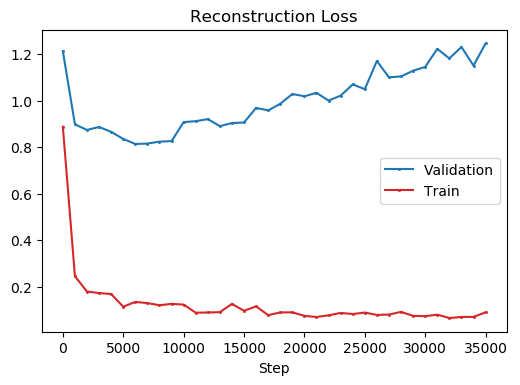

In [8]:
train_loss_, i = 0, 0
valid_loss, train_loss, steps = [], [], []
while i < nTrain:
    batch = next(batch_generator)
    train_loss_, _ = sess.run([loss, train_op], feed_dict={x: batch})
    if (i % test_step == 0):
        valid_loss_ = sess.run(loss, feed_dict={x: data_valid})
        valid_loss.append(valid_loss_)
        steps.append(i)
        train_loss.append(train_loss_)
        print("Step {0}: valid={1:.5g}  train={2:.5g}".format(i, valid_loss_, train_loss_))
        
        # plot
        plt.close("all")
        fig, ax = plt.subplots(dpi=100)
        ax.set_title("Reconstruction Loss")
        ax.set_xlabel("Step")
        ax.plot(steps, valid_loss, '-s', ms=1, color="tab:blue", label="Validation")
        ax.plot(steps, train_loss, '-s', ms=1, color="tab:red", label="Train")
        ax.legend()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
    i += 1
valid_loss = sess.run(loss, feed_dict={x: data_valid})
print("Step {0}: valid={1:.5g}  train={2:.5g}".format(i, valid_loss_, train_loss_))

Testing the model on the whole data

In [9]:
def reconstruct(data):
    global x, z, sess, dist
    latent, distance = sess.run([z, dist], feed_dict={x: data})
    return latent, distance, np.mean(distance, axis=1)

latent_normal, distance_normal, error_normal = reconstruct(data_normal[:,1:])
latent_worn, distance_worn, error_worn = reconstruct(np.concatenate([worn_.values for worn_ in worn])[:,1:])

Scatter the data in latent space

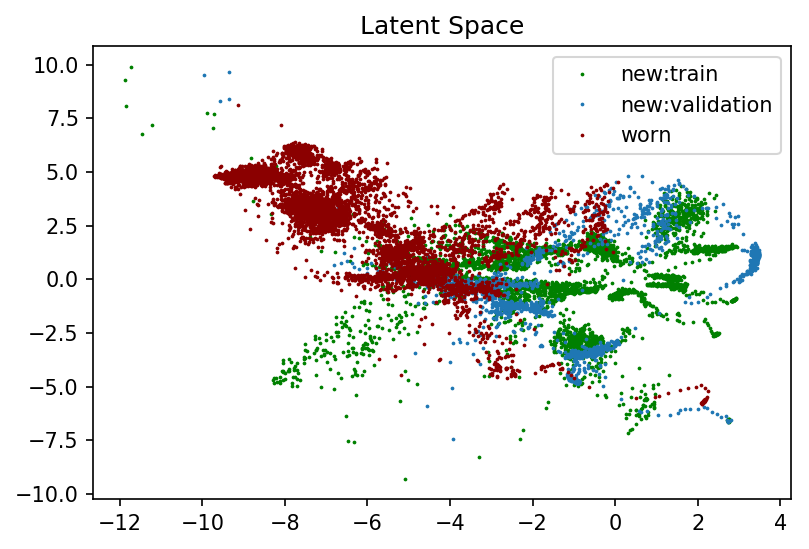

In [10]:
plt.close("all")
fig, ax = plt.subplots(dpi=150)
ax.set_title("Latent Space")

_ = ax.plot(latent_normal[:-valid_size, 0], latent_normal[:-valid_size, 1], "o", ms=.8, color="green", label="new:train")
_ = ax.plot(latent_normal[-valid_size:, 0], latent_normal[-valid_size:, 1], "o", ms=0.8, color="tab:blue", label="new:validation")
_ = ax.plot(latent_worn[:,0], latent_worn[:,1], "o", ms=.8, color="darkred", label="worn")

_ = ax.legend()


### 4. System Health Estimation<a name="SystemHealth"></a>
Plot the reconstruction error in time for train, test and validation

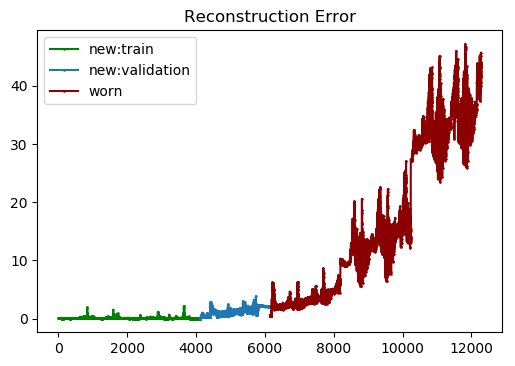

In [11]:
fig, ax = plt.subplots(dpi=100)
ax.set_title("Reconstruction Error")

_ = ax.plot(np.arange(n - valid_size), error_normal[:-valid_size], "-s", ms=.8, color="green", label="new:train")
_ = ax.plot(np.arange(n - valid_size, n), error_normal[-valid_size:], "-s", ms=.8, color="tab:blue", label="new:validation")
_ = ax.plot(np.arange(n, n + len(error_worn)), error_worn, "-s", ms=.8, color="darkred", label="worn")

_ = ax.legend()

#plt.yscale("log")

We can convert this number into an effective system health state by renormalizing the reconstruction error ($L$) such that 99% health corresponds to the maximum error from the healthy-set and 1% to the maximum error overall on a logistic scale

$$\mathrm{SystemHealth} = \frac{1}{1 + \mathrm{e}^{-(a*L + b)}}$$

We could also define this on a linear scale (100%=Minimum Error, 0%=Maximum Error). However, technically it would then be possible to get both negative or larger than 100% system health states which we would like to avoid.

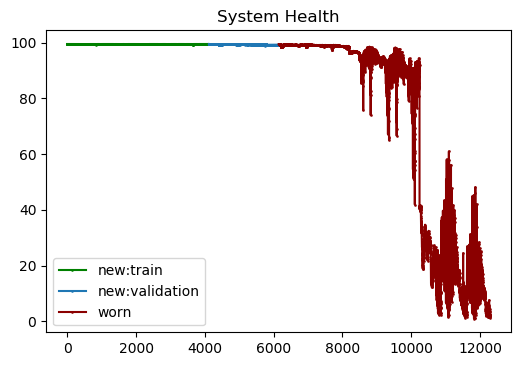

In [12]:
max_train = np.amax(error_normal)
max_full = max(max_train, np.amax(error_worn))

sh_train = 0.99
sh_worn = 0.01
expit = lambda x: 1./(1 + np.exp(-x))
logit = lambda p: np.log(p/(1 - p))

a = -(logit(sh_train) - logit(sh_worn))/(max_full - max_train)
b = -(logit(sh_worn)*max_train - logit(sh_train)*max_full)/(max_full - max_train)
system_health = lambda error: 100*expit(a*error + b)

fig, ax = plt.subplots(dpi=100)
ax.set_title("System Health")

_ = ax.plot(np.arange(n - valid_size), system_health(error_normal[:-valid_size]), "-s", ms=.8, color="green", label="new:train")
_ = ax.plot(np.arange(n - valid_size, n), system_health(error_normal[-valid_size:]), "-s", ms=.8, color="tab:blue", label="new:validation")
_ = ax.plot(np.arange(n, n + len(error_worn)), system_health(error_worn), "-s", ms=.8, color="darkred", label="worn")

_ = ax.legend()

### 5. Anomaly Localization<a name="AnomalyLocalization"></a>

We can find out more about the breakdown by looking at the individual contribution of each feature to the reconstruction loss.

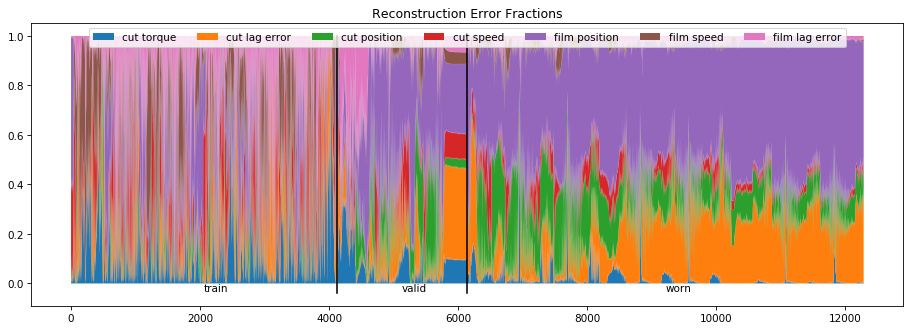

In [13]:
distance_all = np.concatenate((distance_normal, distance_worn))
fractions = (distance_all.T/np.sum(distance_all, axis=1)).T
t = np.arange(len(fractions))

fig, ax = plt.subplots(figsize=(15,5), dpi=75)
ax.set_title("Reconstruction Error Fractions")

for j in range(p):
    lower = np.sum(fractions[:,:j], axis=1)
    upper = np.sum(fractions[:,:j + 1], axis=1)
    ax.fill_between(t, lower, upper, label=new[0].columns[j + 1])
    
ax.plot([n - valid_size, n - valid_size], [-0.04, 1], color="black")
ax.plot([n, n], [-0.04, 1], color="black")
ax.text((n - valid_size)//2, -0.03, "train")
ax.text((n - valid_size) + valid_size//2, -0.03, "valid")
ax.text(n + (len(fractions)- n)//2, -0.03, "worn")

_ = ax.legend(loc="upper center", ncol=p)

Apparently, the *film position* is responsible for the bulk of the reconstruction error. We can check the last few thousand data points and average 

In [14]:
means = np.mean(fractions[-1000:], axis=0)
for i, amean in enumerate(means):
    print("{0: <15s}: {1:0.2f}%".format(new[0].columns[i+1], amean*100))

cut torque     : 0.53%
cut lag error  : 27.17%
cut position   : 10.92%
cut speed      : 1.97%
film position  : 57.63%
film speed     : 0.41%
film lag error : 1.36%


Plotting the *film position* signal for both healthy (upper) and worn (lower) system shows why it is challenging for the autoencoder to reconstruct this data. Even though the shape of the curve is very similar, the absolute scale is quite different.

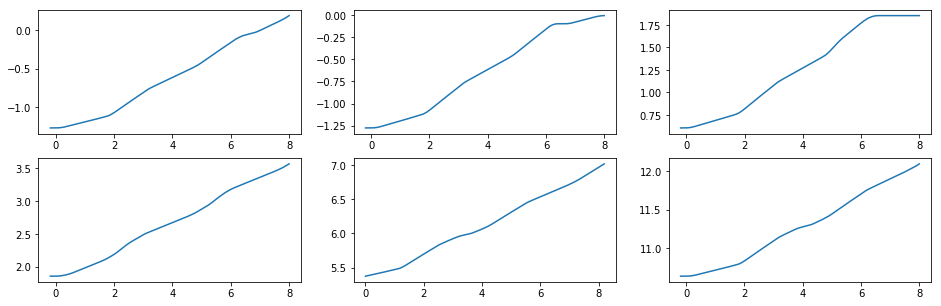

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

col = "film position"
for i in range(3):
    axes[0,i].plot(new[i]["timestamp"], new[i][col])
    axes[1,i].plot(worn[i]["timestamp"], worn[i][col])

#### References

[1] von Birgelen, Alexander; Buratti, Davide; Mager, Jens; Niggemann, Oliver: Self-Organizing Maps for Anomaly Localization and Predictive Maintenance in Cyber-Physical Production Systems. In: 51st CIRP Conference on Manufacturing Systems (CIRP CMS 2018) CIRP-CMS, May 2018.